In [1]:
import tensorflow as tf
from tensorflow.keras import layers

### Positional Encoding
class PositionalEncoding(layers.Layer):
    def __init__(self, position, d_model):
        super().__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, pos, i, d_model):
        angles = pos / tf.pow(10000, (2 * (i//2)) / tf.cast(d_model, tf.float32))
        return angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            pos=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        return pos_encoding[tf.newaxis, ...]

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### Scaled Dot Product Attention
def scaled_dot_product_attention(q, k, v, mask):     #(Q, K, V는 다 4D 텐서: (batch_size, num_heads, seq_len, depth))
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [2]:
### Multi-Head Attention
class MultiHeadAttention(layers.Layer):          #num_head = 헤드개수 <예)8개>
    def __init__(self, d_model, num_heads):        #d_model: 전체 출력 차원 (예: 512)
        super().__init__()
        assert d_model % num_heads == 0

        self.num_heads = num_heads
        self.depth = d_model // num_heads

        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        self.dense = layers.Dense(d_model)      #여러 head를 만들려면 Q, K, V를 한번 linear transform 해줘야 함. (독립적으로 head들이 일할 수 있도록)
#마지막에 여러 head를 이어붙인 걸 다시 d_model 크기로 맞춰주는 Dense 레이어.
    def split_heads(self, x, batch_size):
      ## 1. (batch_size, seq_len, d_model) → (batch_size, seq_len, num_heads, depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask=None):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, _ = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.num_heads * self.depth))

        output = self.dense(concat_attention)
        return output


   #[입력 Q, K, V]
       #  -> (각각 Dense에 통과)
       #  -> (split_heads로 여러 head로 나눔)
       #  -> (각 head마다 scaled dot-product attention 계산)
       #  -> (head들 concat)
       #  -> (마지막 Dense로 출력)

In [3]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [4]:
### Encoder Layer
class EncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)

        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, mask=None, training=False):
        attn_output = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [5]:
### Encoder
class Encoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 input_vocab_size, maximum_position_encoding, rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(maximum_position_encoding, d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        self.dropout = layers.Dropout(rate)

    def call(self, x, mask=None, training=False):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = self.pos_encoding(x)
        x = self.dropout(x, training=training)

        for enc_layer in self.enc_layers:
            x = enc_layer(x, mask=mask, training=training)

        return x  # (batch_size, input_seq_len, d_model)

In [6]:
### Transformer Classifier (Main Model)
#class TransformerClassifier(tf.keras.Model):
#    def __init__(self, num_layers, d_model, num_heads, dff,
#                 input_vocab_size, maximum_position_encoding,
#                 num_classes=4, rate=0.1):
#        super().__init__()

        #self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                             #  input_vocab_size, maximum_position_encoding, rate)
       # self.dropout = layers.Dropout(rate)
       # self.classifier = layers.Dense(num_classes, activation='softmax')

#    def call(self, inputs, training=False):
 #       mask = create_padding_mask(inputs)
  #      x = self.encoder(inputs, mask = mask, training=training)  # (batch_size, seq_len, d_model)
   #     cls_token = x[:, 0, :]
    #    x = self.dropout(cls_token, training=training)
     #   return self.classifier(x)                   # (batch_size, num_classes)

In [7]:
class TransformerClassifier(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 input_vocab_size, maximum_position_encoding,
                 num_classes=4, rate=0.3):  # dropout 약간 증가
        super().__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               input_vocab_size, maximum_position_encoding, rate)
        self.dropout = layers.Dropout(rate)
        # classifier에 hidden layer 하나 추가
        self.classifier = tf.keras.Sequential([
            layers.Dense(d_model, activation='relu'),
            layers.Dropout(rate),
            layers.Dense(num_classes, activation='softmax')
        ])
        self.layernorm = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training=False):
        mask = create_padding_mask(inputs)
        x = self.encoder(inputs, mask=mask, training=training)  # (batch_size, seq_len, d_model)
        cls_token = x[:, 0, :]  # CLS 토큰만 사용
        x = self.dropout(cls_token, training=training)
        return self.classifier(x)


In [8]:
#########################################################################################################################

In [9]:
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer

# 1. 헤더 없는 CSV 로드
data_train = pd.read_csv("twitter_training.csv", header=None)
data_test= pd.read_csv("twitter_validation.csv", header=None)
data_train.columns = ["Tweet ID", "Entity", "Sentiment", "Tweet comment"]
data_test.columns = ["Tweet ID", "Entity", "Sentiment", "Tweet comment"]
# 2. 필요 없는 열 제거
data_train = data_train.drop(columns=["Tweet ID"])
data_test = data_test.drop(columns=["Tweet ID"])
# 3. 소문자 변환
data_train["Tweet comment"] = data_train["Tweet comment"].astype(str).str.lower()
data_train["Entity"] = data_train["Entity"].astype(str).str.lower()

data_test["Tweet comment"] = data_test["Tweet comment"].astype(str).str.lower()
data_test["Entity"] = data_test["Entity"].astype(str).str.lower()

data_all = pd.concat([data_train, data_test], axis=0, ignore_index=True)

#결측치 확인
data_all.isnull().sum()

,0
Entity,0
Sentiment,0
Tweet comment,0


In [10]:
print(len(data_all))

75682


In [11]:
# 4. input_text 생성
#data_all["input_text"] = data_all.apply(
#    lambda x: f"{x['Tweet comment']} [SEP] {x['Entity']}",
#    axis=1
#)  #[CLS] 문장1 [SEP] 문장2 [SEP]

def build_prompt_text(row):
    entity = row["Entity"]
    tweet = row["Tweet comment"]
    return f'What is the sentiment toward "{entity}" in this text? [SEP] {tweet}'

data_all["input_text"] = data_all.apply(build_prompt_text, axis=1)

data_all["input_text"].head()


,input_text
0,"What is the sentiment toward ""borderlands"" in ..."
1,"What is the sentiment toward ""borderlands"" in ..."
2,"What is the sentiment toward ""borderlands"" in ..."
3,"What is the sentiment toward ""borderlands"" in ..."
4,"What is the sentiment toward ""borderlands"" in ..."


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

최소 길이: 15
최대 길이: 328
평균 길이: 47.06622446552681
중간값 길이: 43.0
95% percentile: 88.0
99% percentile: 106.0


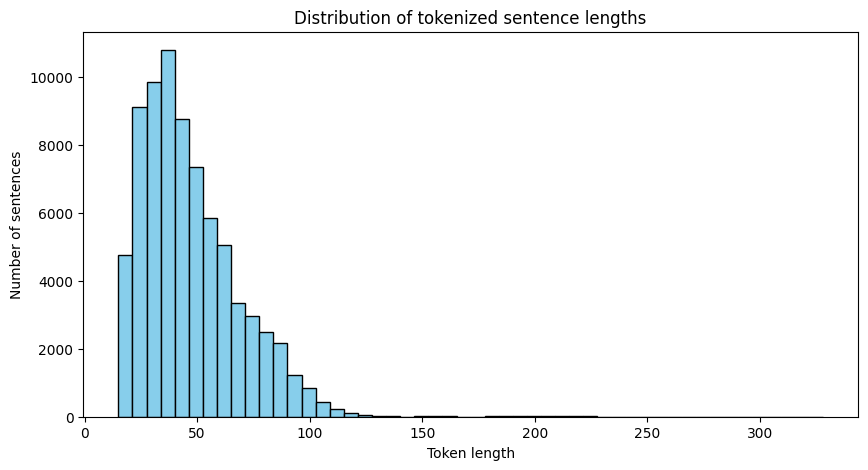

In [12]:
import matplotlib.pyplot as plt
import numpy as np
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

##########################------max_len을 결정하기 위해서 토큰수의 분포를 본다.------########################################
encodings_all_raw = tokenizer(
    data_all["input_text"].tolist(),
    truncation=False,       # 길이 조사할 때는 절대 truncate 하면 안됨
    padding=False,          # 패딩도 넣으면 안됨
)

# 각 문장의 토큰 길이 계산
# Tensor → numpy로 변환 (TF나 Torch 상관없이 안전)
input_ids = encodings_all_raw["input_ids"]

# 각 샘플의 실제 토큰 길이 계산 (패딩 없이 원래 길이)
token_lengths = [len(ids) for ids in input_ids]
# 또는 패딩이 0이 아니라 [PAD] 토큰이라면 np.count_nonzero != pad_id 사용해야 함

# 1. 통계 확인
print("최소 길이:", np.min(token_lengths))
print("최대 길이:", np.max(token_lengths))
print("평균 길이:", np.mean(token_lengths))
print("중간값 길이:", np.median(token_lengths))
print("95% percentile:", np.percentile(token_lengths, 95))
print("99% percentile:", np.percentile(token_lengths, 99))

# 2. 히스토그램 시각화
plt.figure(figsize=(10,5))
plt.hist(token_lengths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Token length")
plt.ylabel("Number of sentences")
plt.title("Distribution of tokenized sentence lengths")
plt.show()



In [13]:
encodings_all = tokenizer(
    data_all["input_text"].tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="tf",
    add_special_tokens=True
)


# 6. 라벨 인코딩
label_map = {"Negative": 0, "Neutral": 1, "Positive": 2, "Irrelevant": 3}  #라벨 맵핑

data_all["label"] = data_all["Sentiment"].map(label_map)
labels = data_all["label"].values

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [14]:
from collections import Counter

# 각 클래스별 샘플 수 확인
print(Counter(labels))


Counter({np.int64(0): 22808, np.int64(2): 21109, np.int64(1): 18603, np.int64(3): 13162})


In [15]:
example = data_all["input_text"].iloc[0]

print(tokenizer.tokenize(example))
print(tokenizer.encode(example))  # 숫자 토큰
#cls가 101、 sep가 102이다。

['what', 'is', 'the', 'sentiment', 'toward', '"', 'border', '##lands', '"', 'in', 'this', 'text', '?', '[SEP]', 'im', 'getting', 'on', 'border', '##lands', 'and', 'i', 'will', 'murder', 'you', 'all', ',']
[101, 2054, 2003, 1996, 15792, 2646, 1000, 3675, 8653, 1000, 1999, 2023, 3793, 1029, 102, 10047, 2893, 2006, 3675, 8653, 1998, 1045, 2097, 4028, 2017, 2035, 1010, 102]


In [16]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

x = encodings_all["input_ids"]
y = labels    #정답 레이블

x_np = x.numpy() if tf.is_tensor(x) else x
y_np = y.numpy() if tf.is_tensor(y) else y


# x: input_ids
# y: labels

# 1) 먼저 train (80%) + temp (20%) 분리
x_train, x_temp, y_train, y_temp = train_test_split(
    x_np, y_np,
    test_size=0.20,    # 20% 남겨두기
    stratify=y_np,
    shuffle=True,
    random_state=42
)

# 2) temp(30%)를 다시 val(10%) + test(10%) 비율로 나눔
#    temp 30% 중 val = 1/2 -> 전체의 20%
#    temp 30% 중 test = 1/2 -> 전체의 10%
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp,
    test_size=1/2,     # temp의 1/2 = 전체의 10%
    stratify=y_temp,
    shuffle=True,
    random_state=42
)

# One-hot encoding
y_train_1 = tf.one_hot(y_train, depth=4)
y_val_1   = tf.one_hot(y_val, depth=4)
y_test_1  = tf.one_hot(y_test, depth=4)

# Dataset 생성
batch_size = 16

train = tf.data.Dataset.from_tensor_slices((x_train, y_train_1)).shuffle(10000).batch(batch_size)
val   = tf.data.Dataset.from_tensor_slices((x_val, y_val_1)).batch(batch_size)
test  = tf.data.Dataset.from_tensor_slices((x_test, y_test_1)).batch(batch_size)

print("Train size:", len(x_train))
print("Val size:", len(x_val))
print("Test size:", len(x_test))


Train size: 60545
Val size: 7568
Test size: 7569


In [17]:
print(labels[:20])


[2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 2 2]


In [18]:
print(y_val[:20])



[2 1 3 0 3 3 1 0 0 2 3 0 3 3 0 1 2 3 3 1]


In [19]:
y_test

array([1, 2, 2, ..., 0, 1, 0])

In [20]:
#num_layers = 2
#d_model = 128
#num_heads = 4
#dff = 256
#vocab_size = tokenizer.vocab_size
#max_len = 128
#num_classes = 4   # negative / neutral / positive / irrelevant


#num_layers = 3      # 레이어 1개 늘려서 모델 깊게
#d_model = 256       # 표현력 증가
#num_heads = 8       # 멀티헤드 늘리기 (d_model % num_heads = 0)
#dff = 512           # FFN 용량 증가
#max_len = 128       # 그대로

#num_layers = 3      # 레이어 1개 추가
#d_model = 256       # 임베딩 차원 증가
#num_heads = 8       # 멀티헤드 증가 (d_model % num_heads == 0)
          # FFN 내부 차원 증가
vocab_size = tokenizer.vocab_size


model = TransformerClassifier(
    num_layers=3,
    d_model=256,
    num_heads=4,
    dff=512,
    input_vocab_size=vocab_size,
    maximum_position_encoding= 170,
    num_classes= 4,
    rate=0.2
)
epochs = 30


In [21]:


print(x_train.shape)  # (샘플 수, 시퀀스 길이)여야 함

from sklearn.utils import class_weight
import numpy as np

classes = np.array([0, 1, 2, 3])
y_labels = y_np  # 라벨 배열

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_labels
)

class_weights_dict = dict(zip(classes, class_weights))
print(class_weights_dict)


(60545, 128)
{np.int64(0): np.float64(0.829555419151175), np.int64(1): np.float64(1.017067139708649), np.int64(2): np.float64(0.8963238429106068), np.int64(3): np.float64(1.4375094970369244)}


In [22]:
import tensorflow as tf
import math

class WarmupCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self,
                 initial_lr,
                 warmup_steps,
                 total_steps):
        super().__init__()
        self.initial_lr = initial_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)

        # Warmup
        warmup_lr = self.initial_lr * (step / self.warmup_steps)

        # Cosine Decay
        progress = (step - self.warmup_steps) / (self.total_steps - self.warmup_steps)
        cosine_decay = 0.5 * (1 + tf.cos(math.pi * progress))
        cosine_lr = self.initial_lr * cosine_decay

        return tf.where(step < self.warmup_steps, warmup_lr, cosine_lr)


total_steps = int((len(x_train) / batch_size) * epochs)
warmup_steps = int(total_steps * 0.1)

lr_schedule = WarmupCosineDecay(
    initial_lr=0.00005,
    warmup_steps=warmup_steps,
    total_steps=total_steps
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=['accuracy']
)


In [23]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7
)

history = model.fit(
    train,
    validation_data=val ,
    epochs=epochs,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)



Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'transformer_classifier', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


3785/3785 ━━━━━━━━━━━━━━━━━━━━ 84s 17ms/step - accuracy: 0.2604 - loss: 1.6189 - val_accuracy: 0.3582 - val_loss: 1.3371
Epoch 2/30
3785/3785 ━━━━━━━━━━━━━━━━━━━━ 53s 14ms/step - accuracy: 0.3662 - loss: 1.3302 - val_accuracy: 0.5782 - val_loss: 1.0165
Epoch 3/30
3785/3785 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.5907 - loss: 0.9990 - val_accuracy: 0.7076 - val_loss: 0.7481
Epoch 4/30
3785/3785 ━━━━━━━━━━━━━━━━━━━━ 54s 14ms/step - accuracy: 0.7307 - loss: 0.7008 - val_accuracy: 0.7940 - val_loss: 0.5399
Epoch 5/30
3785/3785 ━━━━━━━━━━━━━━━━━━━━ 54s 14ms/step - accuracy: 0.8058 - loss: 0.5179 - val_accuracy: 0.8385 - val_loss: 0.4445
Epoch 6/30
3785/3785 ━━━━━━━━━━━━━━━━━━━━ 54s 14ms/step - accuracy: 0.8482 - loss: 0.4064 - val_accuracy: 0.8611 - val_loss: 0.4075
Epoch 7/30
3785/3785 ━━━━━━━━━━━━━━━━━━━━ 54s 14ms/step - accuracy: 0.8759 - loss: 0.3279 - val_accuracy: 0.8725 - val_loss: 0.3708
Epoch 8/30
3785/3785 ━━━━━━━━━━━━━━━━━━━━ 54s 14ms/step - accuracy: 0.8975 - loss: 0.27

In [24]:
model.build(input_shape=(None, 170))
model.summary()


Model: "transformer_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │     9,394,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 4)              │        66,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_6           │ ?                      │   0 (unbuilt) │
│ (LayerNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,385,293 (108.28 MB)

 Trainable params: 9,461,764 (36.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,923,529 (72.19 MB)

In [25]:
y_pred = model.predict(test)
y_pred_labels = tf.argmax(y_pred, axis=1).numpy()


474/474 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


In [26]:
y_true = y_test  # 정수 라벨 (원핫 아님!!!11)


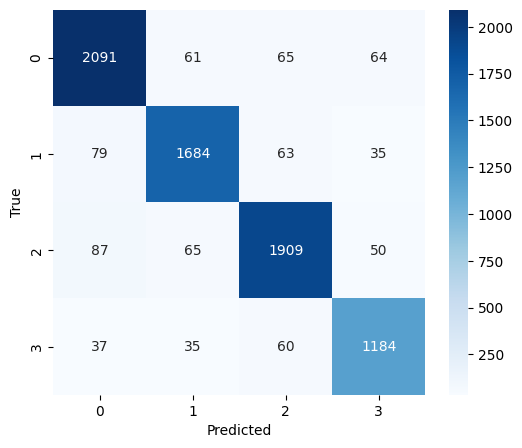

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


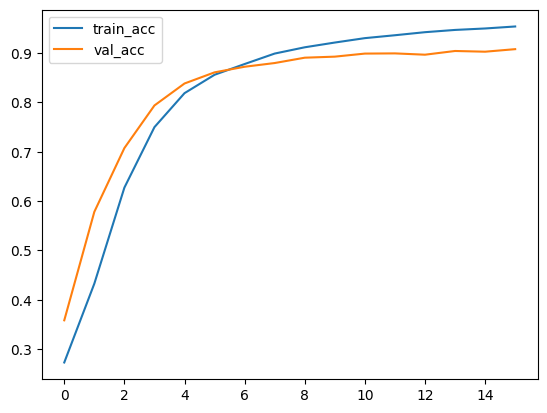

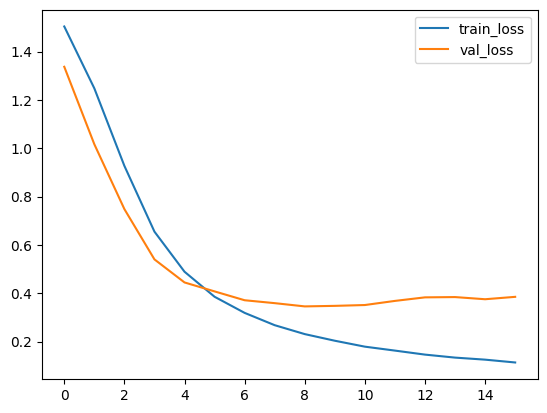

In [28]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_acc', 'val_acc'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.show()


In [29]:
import numpy as np
import tensorflow as tf

def preprocess_sentence(sentence, entity, tokenizer, max_len=128):   #직접 문장 넣어서 확인해보기
    sentence = sentence.lower()
    entity = entity.lower()

    combined = "[CLS] " + sentence + " [SEP] " + entity

    encoded = tokenizer(
        combined,
        add_special_tokens=False,   #직접 CLS/SEP 넣었으니까
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="np"
    )["input_ids"]

    return encoded  # (1, max_len)


def predict_sentiment(model, sentence, entity, tokenizer, max_len=128):
    x = preprocess_sentence(sentence, entity, tokenizer, max_len)

    preds = model.predict(x)
    label_id = np.argmax(preds)

    id2label = {
        0: "negative",
        1: "neutral",
        2: "positive",
        3: "irrelevant"
    }

    return id2label[label_id], preds



# ============================
# 테스트 실행
# ============================

sentence = "so i spent a few hours doing something for fun... if you don't know i'm a huge @ borderlands fan and maya is one of my favorite characters."
entity = "borderlands"

label, raw = predict_sentiment(model, sentence, entity, tokenizer)

print("예측 라벨:", label)
print("raw:", raw)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
예측 라벨: positive
raw: [[9.3720817e-05 6.1306375e-05 9.9983990e-01 5.0317958e-06]]


In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# 모델 예측
y_pred_probs = model.predict(test)
y_pred_labels = y_pred_probs.argmax(axis=1)

# 각 지표 계산
precision = precision_score(y_true, y_pred_labels, average='macro')
recall    = recall_score(y_true, y_pred_labels,   average='macro')
f1        = f1_score(y_true, y_pred_labels,       average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# 클래스별 상세 보고서
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred_labels))


474/474 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Precision: 0.9057038954294692
Recall: 0.90639996158757
F1-score: 0.9060341333094245

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2281
           1       0.91      0.90      0.91      1861
           2       0.91      0.90      0.91      2111
           3       0.89      0.90      0.89      1316

    accuracy                           0.91      7569
   macro avg       0.91      0.91      0.91      7569
weighted avg       0.91      0.91      0.91      7569

